<h1 style="background-color: #ffd5cd; text-align: center"> Extracting Financial 10-K Statements from SEC'S EDGAR Database</h1>

In [34]:
# %conda init
# %conda deactivate
# %conda activate credit-analysis-dashboard
# %conda install numpy pandas requests bs4 tqdm openai matplotlib seaborn 
# %conda install -c conda-forge ratelimit lxml statsmodels 
# %conda install conda-forge::nltk

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra, arithmentic calculations
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

<h1 style="background-color: #ffd5cd; text-align: center">Exploratory Data Analysis</h1>

In [ ]:
!pip install scikit-learn


In [40]:
import pandas as pd
import os

DATA_INPUT_DIR = "C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2025_02_notes/"

sub = pd.read_csv(os.path.join(DATA_INPUT_DIR, "sub.tsv"), sep='\t', low_memory=False)
num = pd.read_csv(os.path.join(DATA_INPUT_DIR, "num.tsv"), sep='\t', low_memory=False)
tag = pd.read_csv(os.path.join(DATA_INPUT_DIR, "tag.tsv"), sep='\t', low_memory=False)

print("Files loaded successfully!")


Files loaded successfully!


In [41]:
key_tags = {
    'NetIncomeLoss': 'Net Income',
    'Assets': 'Total Assets',
    'StockholdersEquity': 'Shareholder Equity',
    'NetCashProvidedByUsedInOperatingActivities': 'Cash From Ops',
    'Revenues': 'Revenue'
}

num_filtered = num[num['tag'].isin(key_tags.keys())].copy()
num_filtered['metric_name'] = num_filtered['tag'].map(key_tags)
num_filtered = num_filtered.merge(sub[['adsh', 'cik', 'name', 'fy', 'fp', 'form']], on='adsh', how='left')

edf = num_filtered.pivot_table(
    index=['cik', 'name', 'adsh', 'fy', 'fp', 'form'],
    columns='metric_name',
    values='value',
    aggfunc='first'
).reset_index()

edf['ROE'] = edf['Net Income'] / edf['Shareholder Equity']
edf['ROA'] = edf['Net Income'] / edf['Total Assets']
edf['ROI'] = edf['Net Income'] / edf['Total Assets']

edf.info()
edf.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2716 entries, 0 to 2715
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cik                 2716 non-null   int64  
 1   name                2716 non-null   object 
 2   adsh                2716 non-null   object 
 3   fy                  2716 non-null   float64
 4   fp                  2716 non-null   object 
 5   form                2716 non-null   object 
 6   Cash From Ops       2567 non-null   float64
 7   Net Income          2471 non-null   float64
 8   Revenue             1228 non-null   float64
 9   Shareholder Equity  2435 non-null   float64
 10  Total Assets        2709 non-null   float64
 11  ROE                 2310 non-null   float64
 12  ROA                 2464 non-null   float64
 13  ROI                 2464 non-null   float64
dtypes: float64(9), int64(1), object(4)
memory usage: 297.2+ KB


c:\Users\natal\anaconda3\envs\credit-analysis-dashboard\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


metric_name,cik,fy,Cash From Ops,Net Income,Revenue,Shareholder Equity,Total Assets,ROE,ROA,ROI
count,2.716000e+03,2716.000000,2.567000e+03,2.471000e+03,1.228000e+03,2.435000e+03,2.709000e+03,2310.000000,2464.000000,2464.000000
mean,1.207000e+06,2024.188881,9.608174e+08,4.469782e+08,6.928019e+09,3.423049e+09,3.524389e+10,NaN,-inf,-inf
std,5.609254e+05,0.438524,4.359354e+09,2.664370e+09,2.586636e+10,1.338096e+10,3.001762e+11,NaN,NaN,NaN
min,1.800000e+03,2018.000000,-7.255858e+09,-2.275900e+10,-1.054000e+09,-1.723300e+10,-1.700000e+07,-inf,-inf,-inf
25%,8.856912e+05,2024.000000,-5.147665e+05,-8.275490e+06,3.104800e+07,5.506850e+07,3.998250e+08,-0.115704,-0.046787,-0.046787
50%,1.339177e+06,2024.000000,1.008940e+08,2.520000e+07,6.800275e+08,6.450050e+08,2.406057e+09,0.040083,0.010524,0.010524
75%,1.653521e+06,2024.000000,5.308700e+08,2.695500e+08,3.938184e+09,2.313972e+09,1.010370e+10,0.160692,0.050490,0.050490
max,2.042694e+06,2025.000000,1.071190e+11,5.997200e+10,4.136800e+11,2.700660e+11,1.192822e+13,inf,66.295682,66.295682


In [42]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def clean_financial_dataframe(df, output_path="C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_clean_full.csv"):
    df_clean = df.copy()

    # 1. Eliminar infinitos y valores faltantes (NaN)
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Eliminar duplicados
    df_clean = df_clean.drop_duplicates()

    # 3. Limpiar campos de texto como 'name' (eliminar espacios y poner en minúsculas)
    if 'name' in df_clean.columns:
        df_clean['name'] = df_clean['name'].astype(str).str.strip().str.lower()

    # 4. Convertir 'fy' (año fiscal) a tipo numérico si existe
    if 'fy' in df_clean.columns:
        df_clean['fy'] = pd.to_numeric(df_clean['fy'], errors='coerce')

    # 5. Eliminar valores atípicos usando percentiles 1% y 99%
    for col in ['Net Income', 'Revenue', 'ROE', 'ROA', 'ROI']:
        if col in df_clean.columns:
            upper_bound = df_clean[col].quantile(0.99)
            lower_bound = df_clean[col].quantile(0.01)
            df_clean = df_clean[(df_clean[col] <= upper_bound) & (df_clean[col] >= lower_bound)]

    # 6. Estandarizar las columnas numéricas
    numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

    # 7. Guardar localmente
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_clean.to_csv(output_path, index=False)

    print(f"Dataset limpio guardado en: {output_path}")
    return df_clean

# Aplicar limpieza al dataset original (edf)
edf_full_clean = clean_financial_dataframe(edf)

edf_full_clean.info()
edf_full_clean.describe()

Dataset limpio guardado en: C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_clean_full.csv
<class 'pandas.core.frame.DataFrame'>
Index: 921 entries, 4 to 2710
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cik                 921 non-null    float64
 1   name                921 non-null    object 
 2   adsh                921 non-null    object 
 3   fy                  921 non-null    float64
 4   fp                  921 non-null    object 
 5   form                921 non-null    object 
 6   Cash From Ops       921 non-null    float64
 7   Net Income          921 non-null    float64
 8   Revenue             921 non-null    float64
 9   Shareholder Equity  921 non-null    float64
 10  Total Assets        921 non-null    float64
 11  ROE                 921 non-null    float64
 12  ROA                 921 non-null    float64
 13  ROI                 921 non-

metric_name,cik,fy,Cash From Ops,Net Income,Revenue,Shareholder Equity,Total Assets,ROE,ROA,ROI
count,9.210000e+02,9.210000e+02,9.210000e+02,921.000000,9.210000e+02,9.210000e+02,9.210000e+02,921.000000,9.210000e+02,9.210000e+02
mean,6.171924e-17,9.020074e-14,-3.085962e-17,0.000000,-3.085962e-17,1.542981e-17,2.314471e-17,0.000000,3.085962e-17,3.085962e-17
std,1.000543e+00,1.000543e+00,1.000543e+00,1.000543,1.000543e+00,1.000543e+00,1.000543e+00,1.000543,1.000543e+00,1.000543e+00
min,-1.894875e+00,-2.867203e+00,-2.794150e+00,-2.032678,-4.678227e-01,-1.094516e+00,-3.339244e-01,-12.293247,-9.032707e+00,-9.032707e+00
25%,-5.360903e-01,-4.130265e-01,-3.976545e-01,-0.365904,-4.628521e-01,-4.057197e-01,-3.238391e-01,0.086918,1.288866e-01,1.288866e-01
50%,1.324437e-01,-4.130265e-01,-3.185275e-01,-0.303983,-3.952654e-01,-3.034551e-01,-2.781153e-01,0.113266,2.018284e-01,2.018284e-01
75%,8.516164e-01,-4.130265e-01,-6.404525e-02,-0.032418,-5.763147e-02,-6.136939e-02,-1.165986e-01,0.143179,2.993922e-01,2.993922e-01
max,1.500892e+00,2.041150e+00,1.288799e+01,8.332612,6.924701e+00,1.243741e+01,1.102143e+01,3.463886,9.383691e-01,9.383691e-01


Este notebook está en desarrollo.

Lo que se ha realizado hasta ahora:

Extracción de entidades a partir de los documentos financieros.

Creación de un conjunto de datos financieros a partir de los informes 10-K preprocesados.

Análisis exploratorio de datos (EDA).


#### Transformación

Transformación de los datos para:
- Poder llevar a cabo los puntos anteriores
- Para poder visualizar los datos con python
- Para poder juntar datos
  - Como hacer un join/merge en pandas
  - Como juntar datos extraídos por una API con un csv
  - Como juntar datos extraídos por web-scrapping con una API
  
Esta etapa puede realizarse con visualizaciones simples y descripciones estadísticas preliminares.

In [43]:
# Define a function to analyze column types
def analyze_data_types(df, df_name):
    if df is None:
        return pd.DataFrame()

    summary = []
    for col in df.columns:
        dtype = df[col].dtype

        if pd.api.types.is_numeric_dtype(dtype):
            classification = 'Numeric'
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            classification = 'Date'
        elif col.lower() in ['fy', 'fp', 'fye', 'filed', 'period', 'date']:
            classification = 'Fiscal/Period Field (Date-like)'
        elif pd.api.types.is_string_dtype(dtype):
            classification = 'Categorical or Text'
        else:
            classification = 'Other'

        summary.append({
            'Dataset': df_name,
            'Column': col,
            'Detected dtype': str(dtype),
            'Classification': classification
        })
    return pd.DataFrame(summary)

In [44]:
# Generate summaries
summary_sub = analyze_data_types(sub, "sub")
print("Summary for 'sub':")
print(summary_sub)

Summary for 'sub':
   Dataset       Column Detected dtype                   Classification
0      sub         adsh         object              Categorical or Text
1      sub          cik          int64                          Numeric
2      sub         name         object              Categorical or Text
3      sub          sic        float64                          Numeric
4      sub    countryba         object              Categorical or Text
5      sub       stprba         object              Categorical or Text
6      sub       cityba         object              Categorical or Text
7      sub        zipba         object              Categorical or Text
8      sub         bas1         object              Categorical or Text
9      sub         bas2         object              Categorical or Text
10     sub         baph         object              Categorical or Text
11     sub    countryma         object              Categorical or Text
12     sub       stprma         object       

In [45]:
summary_num = analyze_data_types(num, "num")
print("Summary for 'num':")
print(summary_num)

Summary for 'num':
   Dataset    Column Detected dtype       Classification
0      num      adsh         object  Categorical or Text
1      num       tag         object  Categorical or Text
2      num   version         object  Categorical or Text
3      num     ddate          int64              Numeric
4      num      qtrs          int64              Numeric
5      num       uom         object  Categorical or Text
6      num      dimh         object  Categorical or Text
7      num      iprx          int64              Numeric
8      num     value        float64              Numeric
9      num  footnote         object  Categorical or Text
10     num   footlen          int64              Numeric
11     num      dimn          int64              Numeric
12     num     coreg         object  Categorical or Text
13     num      durp        float64              Numeric
14     num      datp        float64              Numeric
15     num      dcml          int64              Numeric


In [46]:
# Generate summaries
summary_tag = analyze_data_types(tag, "tag")
print("Summary for 'tag':")
print(summary_tag)


Summary for 'tag':
  Dataset    Column Detected dtype       Classification
0     tag       tag         object  Categorical or Text
1     tag   version         object  Categorical or Text
2     tag    custom          int64              Numeric
3     tag  abstract          int64              Numeric
4     tag  datatype         object  Categorical or Text
5     tag      iord         object  Categorical or Text
6     tag      crdr         object  Categorical or Text
7     tag    tlabel         object  Categorical or Text
8     tag       doc         object  Categorical or Text


In [ ]:
# Concatenate all summaries into a single DataFrame
# combined_summary = pd.concat([summary_sub, summary_num, summary_tag], ignore_index=True)
# print(combined_summary.head(50))  # Show first 50 rows for clarity

C:\Users\natal\AppData\Local\Temp\ipykernel_29736\3835642383.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


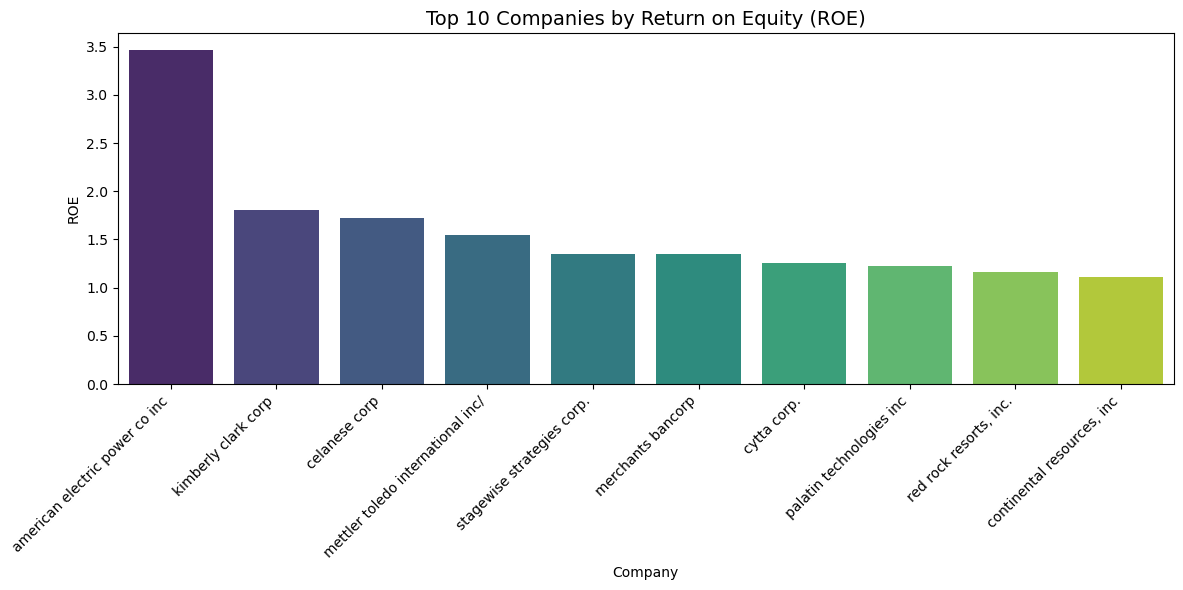

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter, drop NaNs, and select top 10 by ROE
top_10_roe = (
    edf_full_clean.dropna(subset=['ROE'])
    .sort_values(by='ROE', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\natal\AppData\Local\Temp\ipykernel_29736\1332935610.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


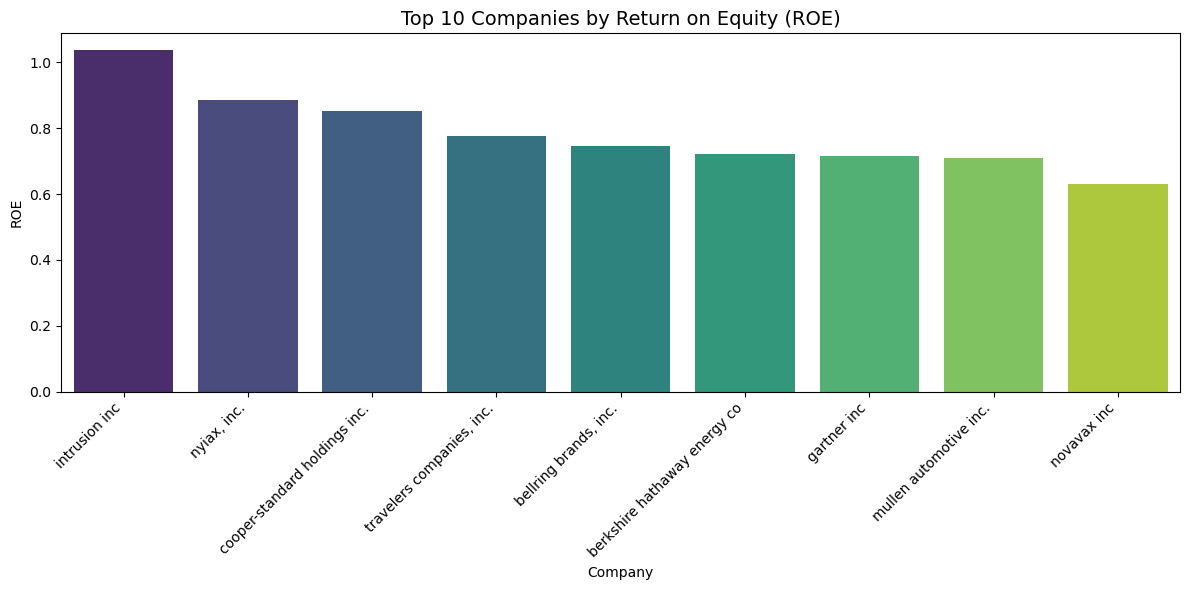

In [48]:
# --- Plot: Top 10 companies by ROE (excluding extreme outliers) ---
filtered_roe = edf_full_clean.dropna(subset=['ROE'])
filtered_roe = filtered_roe[filtered_roe['ROE'] < filtered_roe['ROE'].quantile(0.99)]
top_10_roe = filtered_roe.sort_values(by='ROE', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_29736\3439107295.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


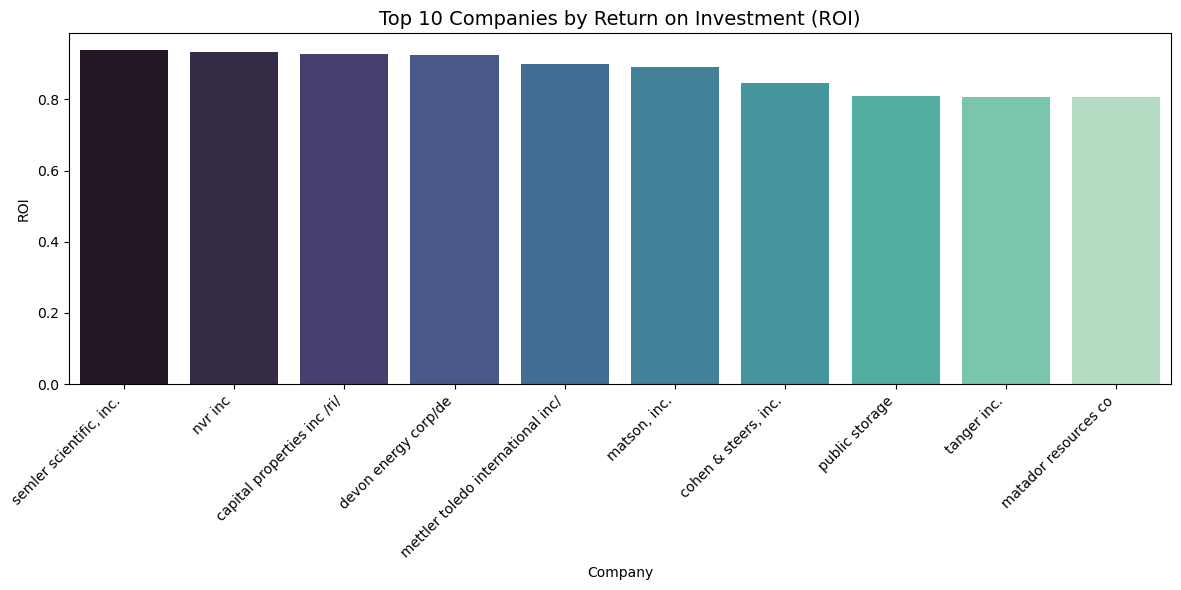

In [49]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf_full_clean.dropna(subset=['ROI'])
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_29736\851940896.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


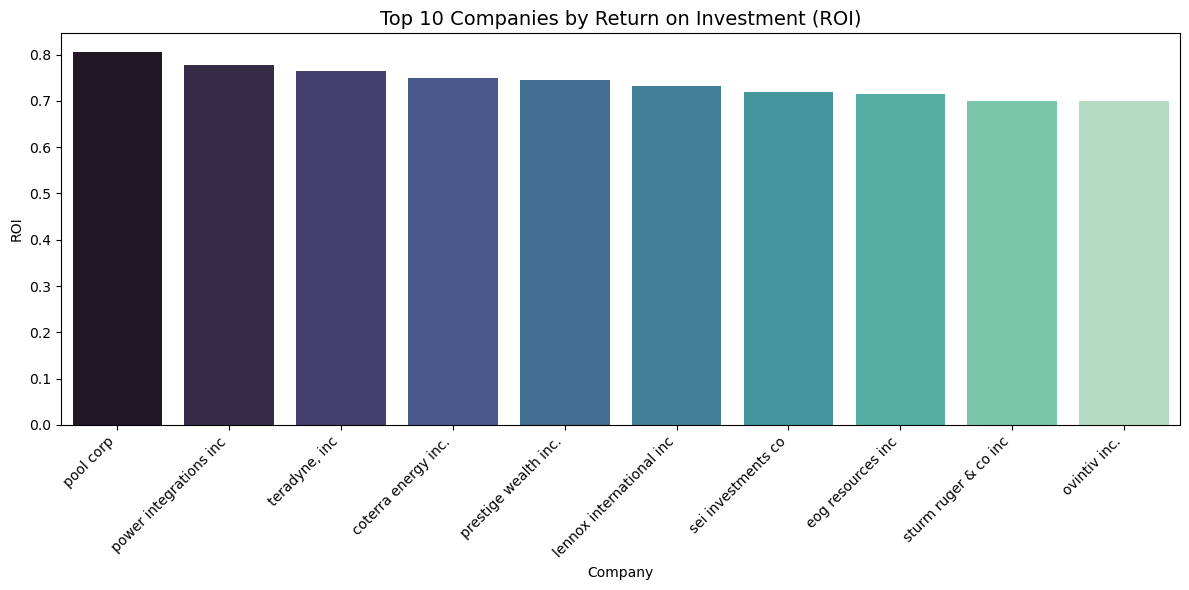

In [50]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf_full_clean.dropna(subset=['ROI'])
filtered_roi = filtered_roi[filtered_roi['ROI'] < filtered_roi['ROI'].quantile(0.99)]
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Estadística

Una vez que comprendemos la estructura básica de los datos, debemos aplicar medidas estadísticas para describir su comportamiento y distribución. Esto incluye:

##### Descriptiva
- Estadísticas de tendencia central: media, mediana, moda
- Medidas de dispersión: rango, varianza, desviación estándar, percentiles
- Distribuciones: histograma, boxplot, KDE
- Estadísticas por subgrupos (segmentación por género, edad, región, etc.)

  
##### Inferencial
- Correlaciones entre variables numéricas
- Contraste de hipótesis: por ejemplo, ¿es diferente la edad del segmento A a la del B?
- Plantear modelo de regresión lineal sobre una variable dependiente en función del resto de datos (por ejemplo  precio de vivienda en función de m2 o numero de habitaciones)
- Unos resultados no-concluyentes, no confirmatorios con la pregunta de investigación inicial o con una muestra muy pequeña son igualmente necesarios siempre que se expliciten las limitaciones. Aunque tengas pocos datos: intenta plantear igualmente estos análisis.

Estas métricas permiten detectar patrones, comportamientos anómalos, y relaciones entre variables que pueden ser clave para responder a las preguntas de investigación.

In [51]:
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for plotting
import seaborn as sns  # Ensure seaborn is also imported for visualization

# --- Estadística Descriptiva ---
print("\nEstadísticas descriptivas básicas:")

# Calcular estadísticas descriptivas principales
desc_stats = edf_full_clean[['Net Income', 'Revenue', 'ROE', 'ROA']].describe().T.copy()

# Agregar mediana y moda
desc_stats['mediana'] = edf_full_clean[['Net Income', 'Revenue', 'ROE', 'ROA']].median()
desc_stats['moda'] = edf_full_clean[['Net Income', 'Revenue', 'ROE', 'ROA']].mode().iloc[0]
desc_stats['rango'] = desc_stats['max'] - desc_stats['min']
desc_stats['varianza'] = edf_full_clean[['Net Income', 'Revenue', 'ROE', 'ROA']].var()

# Renombrar columnas al español
desc_stats = desc_stats.rename(columns={
    'mean': 'media',
    'std': 'desviación estándar',
    'min': 'mínimo',
    '25%': 'percentil 25',
    '50%': 'percentil 50',
    '75%': 'percentil 75',
    'max': 'máximo'
})

# Seleccionar columnas para mostrar
columnas_a_mostrar = ['media', 'mediana', 'moda', 'desviación estándar', 'mínimo', 'máximo',
                      'percentil 25', 'percentil 50', 'percentil 75']

# Transponer para forma "pivot" legible
# --- a. Estadísticas de tendencia central ---
tendencia_central = desc_stats[['media', 'mediana', 'moda']].T
tendencia_central.columns.name = "Métrica"

# --- b. Medidas de dispersión ---
dispersión = desc_stats[['mínimo', 'máximo', 'rango', 'varianza', 'desviación estándar',
                         'percentil 25', 'percentil 50', 'percentil 75']].T
dispersión.columns.name = "Métrica"

print("\nMedidas de tendencia central:")
print(tendencia_central)

print("\nMedidas de dispersión:")
print(dispersión)


Estadísticas descriptivas básicas:

Medidas de tendencia central:
Métrica  Net Income       Revenue       ROE           ROA
media      0.000000 -3.085962e-17  0.000000  3.085962e-17
mediana   -0.303983 -3.952654e-01  0.113266  2.018284e-01
moda      -0.364944 -4.678227e-01  0.095179  1.654441e-01

Medidas de dispersión:
Métrica              Net Income   Revenue        ROE       ROA
mínimo                -2.032678 -0.467823 -12.293247 -9.032707
máximo                 8.332612  6.924701   3.463886  0.938369
rango                 10.365289  7.392524  15.757134  9.971076
varianza               1.001087  1.001087   1.001087  1.001087
desviación estándar    1.000543  1.000543   1.000543  1.000543
percentil 25          -0.365904 -0.462852   0.086918  0.128887
percentil 50          -0.303983 -0.395265   0.113266  0.201828
percentil 75          -0.032418 -0.057631   0.143179  0.299392


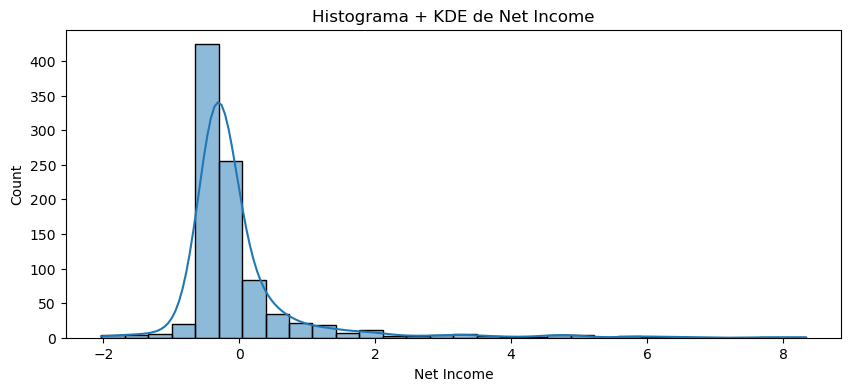

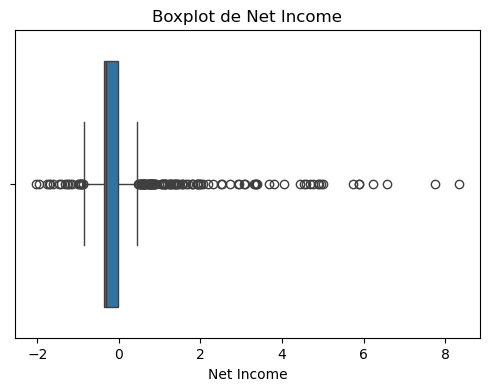

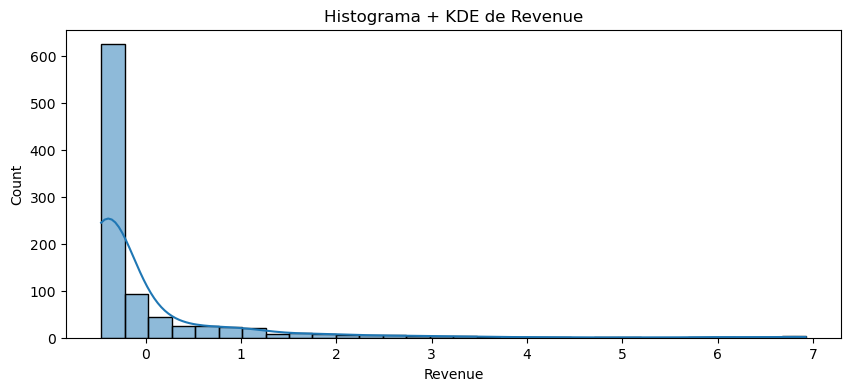

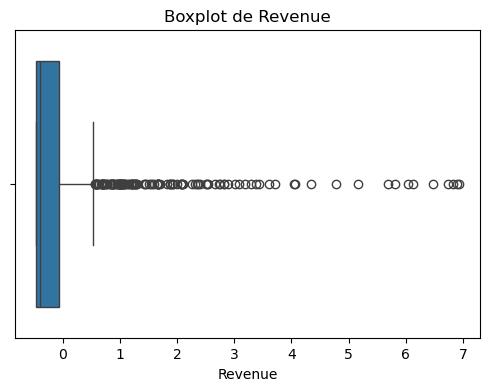

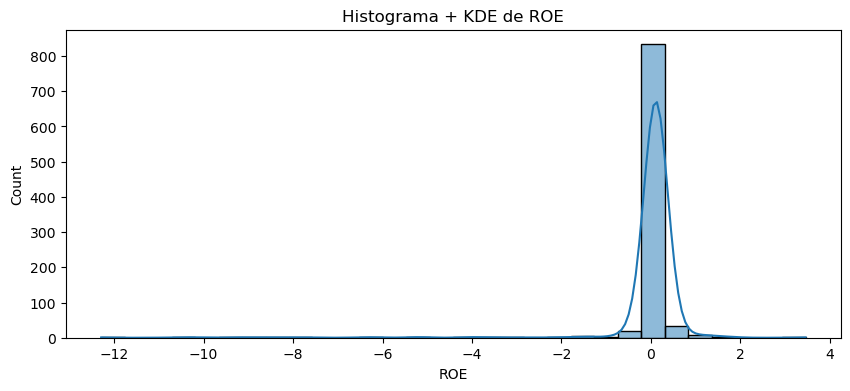

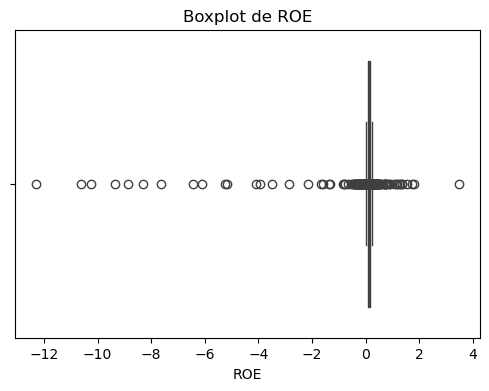

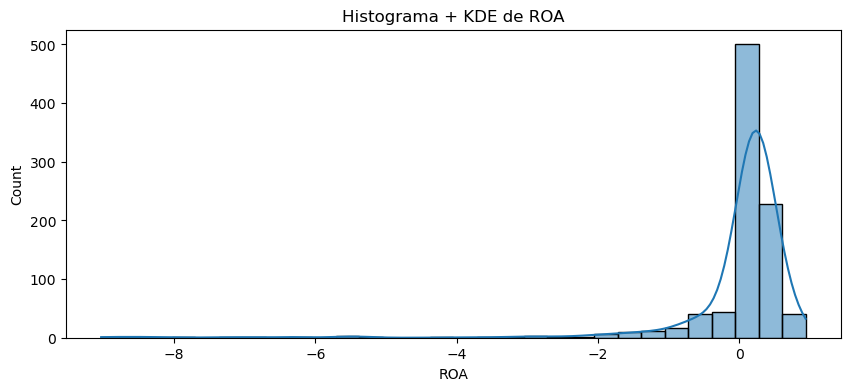

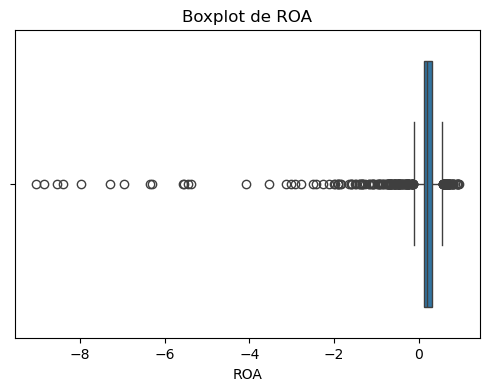


Correlaciones entre métricas financieras:
metric_name  Net Income   Revenue       ROE       ROA
metric_name                                          
Net Income     1.000000  0.563140 -0.009522  0.167461
Revenue        0.563140  1.000000 -0.005128  0.139464
ROE           -0.009522 -0.005128  1.000000 -0.000691
ROA            0.167461  0.139464 -0.000691  1.000000


In [52]:
# --- Histograma y Boxplot ---
for metric in ['Net Income', 'Revenue', 'ROE', 'ROA']:
    plt.figure(figsize=(10, 4))
    sns.histplot(edf_full_clean[metric].dropna(), kde=True, bins=30)
    plt.title(f'Histograma + KDE de {metric}')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=edf_full_clean[metric].dropna())
    plt.title(f'Boxplot de {metric}')
    plt.show()

# --- Correlaciones 
print("\nCorrelaciones entre métricas financieras:")
print(edf_full_clean[['Net Income', 'Revenue', 'ROE', 'ROA']].corr())

Contraste de hipótesis: por ejemplo, ¿es diferente la edad del segmento A a la del B?

In [53]:
# --- Modelo de regresión lineal: ROE ~ Net Income, Revenue ---
import statsmodels.api as sm

model_data = edf_full_clean.dropna(subset=['ROE', 'Net Income', 'Revenue'])
X = model_data[['Net Income', 'Revenue']]
y = model_data['ROE']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("\nResumen del modelo de regresión lineal (ROE ~ Net Income + Revenue):")
print(model.summary())


Resumen del modelo de regresión lineal (ROE ~ Net Income + Revenue):
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04165
Date:                Fri, 04 Apr 2025   Prob (F-statistic):              0.959
Time:                        02:24:44   Log-Likelihood:                -1306.8
No. Observations:                 921   AIC:                             2620.
Df Residuals:                     918   BIC:                             2634.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

The reason your regression output is filled with nan and inf is likely due to extreme values (outliers) or multicollinearity / numerical instability in the variables, especially Net Income and Revenue.

In [54]:
model_data = edf_full_clean[['ROE', 'Net Income', 'Revenue']].copy()
model_data = model_data.dropna()

# Remove outliers using quantiles
q_low = model_data.quantile(0.01)
q_high = model_data.quantile(0.99)
model_data = model_data[(model_data >= q_low) & (model_data <= q_high)].dropna()

# --- Replace inf/-inf and drop remaining NaNs ---
model_data = model_data.replace([np.inf, -np.inf], np.nan).dropna()

# --- Log transformation ---
model_data['log_ni'] = np.log1p(model_data['Net Income'])
model_data['log_rev'] = np.log1p(model_data['Revenue'])


c:\Users\natal\anaconda3\envs\credit-analysis-dashboard\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [55]:
# Ensure no inf/nan remains
model_data = model_data.replace([np.inf, -np.inf], np.nan).dropna()

In [56]:
import numpy as np

X = model_data[['log_ni', 'log_rev']]
y = model_data['ROE']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print("\nResumen del modelo de regresión lineal (ROE ~ log(Net Income) + log(Revenue)):")
print(model.summary())



Resumen del modelo de regresión lineal (ROE ~ log(Net Income) + log(Revenue)):
                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.277
Date:                Fri, 04 Apr 2025   Prob (F-statistic):             0.0382
Time:                        02:24:58   Log-Likelihood:                -338.90
No. Observations:                 871   AIC:                             683.8
Df Residuals:                     868   BIC:                             698.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------